In [1]:
import math
import warnings
import collections
import os
import warnings
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchmeta.modules import MetaBatchNorm2d, MetaConv2d, MetaLinear, MetaModule, MetaSequential
from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters
from tqdm import tqdm

from torchmeta.datasets.helpers import fc100
from torchmeta.transforms import Categorical, ClassSplitter
from torchvision.transforms import Compose, Resize, ToTensor
import multiprocessing

try:
    multiprocessing.set_start_method("spawn")
except RuntimeError:
    print("The start method has already been set.")

warnings.filterwarnings("ignore")

In [2]:
from torchmeta.utils.data import Task

def apply_transforms(task, transforms):
    print("Before transformation:", task)
    if isinstance(task, Task):
        task = transforms(task)
    print("After transformation:", task)
    return task

In [3]:
def get_dataloader(
    config: Dict[str, Any]
) -> Tuple[BatchMetaDataLoader, BatchMetaDataLoader, BatchMetaDataLoader]:

    # Set transforms
    train_transforms = Compose([
        Resize(config["image_size"]),
        ToTensor(),
    ])

    val_transforms = Compose([
        Resize(config["image_size"]),
        ToTensor(),
    ])

    # class_splitter = ClassSplitter(shuffle=True, num_train_per_class=config["num_shots"], num_test_per_class=config["test_shots"])

    train_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_train=True,
        transform=train_transforms,
        target_transform=Categorical(config["num_ways"]),
        # dataset_transform=class_splitter,
        download=config["download"],
    )
    val_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_val=True,
        transform=val_transforms,
        target_transform=Categorical(config["num_ways"]),
        #dataset_transform=class_splitter,
        download=config["download"],
    )
    test_dataset = fc100(
        folder=config["folder_name"],
        shots=config["num_shots"],
        ways=config["num_ways"],
        meta_test=True,
        transform=val_transforms,
        target_transform=Categorical(config["num_ways"]),
        #dataset_transform=class_splitter,
        download=config["download"],
    )
    train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)
    val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)
    test_dataloader = BatchMetaDataLoader(test_dataset, batch_size=config["task_batch_size"], shuffle=True, num_workers=1)

    return train_dataloader, val_dataloader, test_dataloader


In [4]:
class EmbeddingNet(nn.Module):
    def __init__(self, x_dim: int = 3, hid_dim: int = 64, z_dim: int = 64) -> None:
        super(EmbeddingNet, self).__init__()
        self.encoder = nn.Sequential(
            self.conv_block(in_channels=x_dim, out_channels=hid_dim),
            self.conv_block(in_channels=hid_dim, out_channels=hid_dim),
            self.conv_block(in_channels=hid_dim, out_channels=hid_dim),
            self.conv_block(in_channels=hid_dim, out_channels=z_dim),
        )

    @classmethod
    def conv_block(cls, in_channels: int, out_channels: int) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        out = x.view(x.size(0), -1)
        return out

In [5]:
class CasualConv1d(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        dilation: int = 1,
        groups: int = 1,
        bias: int = True,
    ) -> None:
        super(CasualConv1d, self).__init__()
        self.dilation = dilation
        padding = dilation * (kernel_size - 1)
        self.conv1d = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv1d(x)
        return out[:, :, : -self.dilation]

In [6]:
class DenseBlock(nn.Module):
    def __init__(
        self, in_channels: int, dilation: int, filters: int, kernel_size: int = 2
    ) -> None:
        super(DenseBlock, self).__init__()
        self.causal_conv1 = CasualConv1d(
            in_channels, filters, kernel_size, dilation=dilation
        )
        self.causal_conv2 = CasualConv1d(
            in_channels, filters, kernel_size, dilation=dilation
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xf = self.causal_conv1(x)
        xg = self.causal_conv2(x)
        activations = torch.tanh(xf) * torch.sigmoid(xg)
        return torch.cat((x, activations), dim=1)

In [7]:
class TCBlock(nn.Module):
    def __init__(self, in_channels: int, seq_length: int, filters: int) -> None:
        super(TCBlock, self).__init__()
        self.dense_blocks = nn.ModuleList(
            [
                DenseBlock(in_channels + i * filters, 2 ** (i + 1), filters)
                for i in range(int(math.ceil(math.log(seq_length, 2))))
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.transpose(x, 1, 2)
        for block in self.dense_blocks:
            x = block(x)
        return torch.transpose(x, 1, 2)

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels: int, key_size: int, value_size: int) -> None:
        super(AttentionBlock, self).__init__()
        self.query_layer = nn.Linear(in_channels, key_size)
        self.keys_layer = nn.Linear(in_channels, key_size)
        self.values_layer = nn.Linear(in_channels, value_size)
        self.sqrt_key_size = math.sqrt(key_size)
        self.key_size = key_size
        # print(f"In_channels in AttentionBlock: {in_channels}")
        # print(f"key_size in AttentionBlock: {key_size}")
        # print(f"value_size in AttentionBlock: {value_size}")
    @classmethod
    def causally_masked_softmax(
        cls, logits: torch.Tensor, key_size: int
    ) -> torch.Tensor:
        seq_len = logits.shape[1]
        mask = np.array([[i > j for i in range(seq_len)] for j in range(seq_len)])
        mask = torch.BoolTensor(mask).to(logits.get_device())

        logits = logits.data.masked_fill(mask, -float("inf"))
        return F.softmax(logits / math.sqrt(key_size), dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        # print(f"Input shape: {x.shape}") 
        keys = self.keys_layer(x)
        # print(f"Keys shape: {keys.shape}")
        query = self.query_layer(x)
        # print(f"Query shape: {query.shape}") 
        logits = torch.bmm(query, torch.transpose(keys, 1, 2))

        probs = self.causally_masked_softmax(logits, self.key_size)
        values = self.values_layer(x)

        read = torch.bmm(probs, values)
        output = torch.cat((x, read), dim=2)
        # print(f"Output shape: {output.shape}") 
        return output

In [9]:
class SNAIL(nn.Module):
    def __init__(self, num_ways: int, num_shots: int) -> None:
        super(SNAIL, self).__init__()
        self.num_ways, self.num_shots = num_ways, num_shots

        self.encoder = EmbeddingNet()
        num_channels = 256 + num_ways
        num_filters = int(math.ceil(math.log(num_ways * num_shots + 1, 2)))

        self.attention1 = AttentionBlock(num_channels, 64, 32)
        num_channels += 32
        self.tc1 = TCBlock(num_channels, num_ways * num_shots + 1, 128)
        num_channels += num_filters * 128

        self.attention2 = AttentionBlock(num_channels, 256, 128)
        num_channels += 128
        self.tc2 = TCBlock(num_channels, num_ways * num_shots + 1, 128)
        num_channels += num_filters * 128

        self.attention3 = AttentionBlock(num_channels, 512, 256)
        num_channels += 256
        self.fc = nn.Linear(num_channels, num_ways)

    def forward(self, x_seq: torch.Tensor, y_seq: torch.Tensor) -> torch.Tensor:
        # print(f"x_seq shape: {x_seq.shape}")
        # print(f"y_seq shape: {y_seq.shape}")
        x_emb = self.encoder(x_seq)
        batch_size = int(y_seq.size()[0] / (self.num_ways * self.num_shots + 1))

        last_idxs = [
            (i + 1) * (self.num_ways * self.num_shots + 1) - 1
            for i in range(batch_size)
        ]
        y_seq[last_idxs] = torch.Tensor(np.zeros((batch_size, y_seq.size()[1]))).to(
            y_seq.get_device()
        )

        x_cat = torch.cat((x_emb, y_seq), 1)
        x_view = x_cat.view((batch_size, self.num_ways * self.num_shots + 1, -1))

        x_att1 = self.attention1(x_view)
        x_tc1 = self.tc1(x_att1)

        x_att2 = self.attention2(x_tc1)
        x_tc2 = self.tc2(x_att2)

        x_att3 = self.attention3(x_tc2)
        x_out = self.fc(x_att3)
        return x_out

In [10]:
def generate_sequence(
    task_batch: Dict[str, List[torch.Tensor]],
    device: str,
    num_ways: int,
    num_shots: int,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    support_xs = task_batch["train"][0].to(device=device)
    support_ys = task_batch["train"][1].to(device=device)
    query_xs = task_batch["test"][0].to(device=device)
    query_ys = task_batch["test"][1].to(device=device)

    chosen_indices = torch.randint(query_xs.shape[1], size=(query_xs.shape[0],))
    chosen_query_xs = query_xs[
        torch.arange(query_xs.shape[0]), chosen_indices, :, :, :
    ].unsqueeze(1)
    chosen_query_ys = query_ys[
        torch.arange(query_ys.shape[0]), chosen_indices
    ].unsqueeze(1)

    x_seq = torch.cat((support_xs, chosen_query_xs), dim=1).reshape(
        (-1, *support_xs.shape[2:])
    )
    y_seq = torch.cat((support_ys, chosen_query_ys), dim=1).reshape(
        (-1, *support_ys.shape[2:])
    )

    y_seq_onehot = F.one_hot(y_seq).float()

    query_y = y_seq[:: (num_ways * num_shots + 1)].long()

    # print(f"x_seq shape: {x_seq.shape}")
    # print(f"y_seq shape: {y_seq.shape}")
    # print(f"y_seq_onehot shape: {y_seq_onehot.shape}")
    # print(f"query_y shape: {query_y.shape}")
    return x_seq, y_seq_onehot, query_y

In [11]:
def train_snail(
    num_ways: int,
    num_shots: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: SNAIL,
    criterion: nn.CrossEntropyLoss,
    optimizer: torch.optim.Adam,
) -> Tuple[float, float]:
    model.train()

    x_seq, y_seq, query_y = generate_sequence(
        task_batch=task_batch, device=device, num_ways=num_ways, num_shots=num_shots
    )
    x_seq = x_seq.to(device=device)
    y_seq = y_seq.to(device=device)
    query_y = query_y.to(device=device)

    query_prob = model(x_seq, y_seq)[:, -1, :]
    loss = criterion(query_prob, query_y)

    model.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        _, query_preds = query_prob.max(1)
        accuracy = torch.eq(query_preds, query_y).float().mean()
    return accuracy.item(), loss.item()

In [12]:
def test_snail(
    num_ways: int,
    num_shots: int,
    device: str,
    task_batch: Dict[str, List[torch.Tensor]],
    model: SNAIL,
    criterion: nn.CrossEntropyLoss,
) -> Tuple[float, float]:
    model.eval()

    x_seq, y_seq, query_y = generate_sequence(
        task_batch=task_batch, device=device, num_ways=num_ways, num_shots=num_shots
    )
    x_seq = x_seq.to(device=device)
    y_seq = y_seq.to(device=device)
    query_y = query_y.to(device=device)

    query_prob = model(x_seq, y_seq)[:, -1, :]
    loss = criterion(query_prob, query_y)

    with torch.no_grad():
        _, query_preds = query_prob.max(1)
        accuracy = torch.eq(query_preds, query_y).float().mean()
    return accuracy.item(), loss.item()

In [13]:
def save_model(output_folder: str, model: SNAIL, title: str) -> None:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    filename = os.path.join(output_folder, title)

    with open(filename, "wb") as f:
        state_dict = model.state_dict()
        torch.save(state_dict, f)
    print("Model is saved in", filename)


def load_model(output_folder: str, model: SNAIL, title: str) -> None:
    filename = os.path.join(output_folder, title)
    model.load_state_dict(torch.load(filename))
    print("Model is loaded")

In [14]:
def print_graph(
    train_accuracies: List[float],
    val_accuracies: List[float],
    train_losses: List[float],
    val_losses: List[float],
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(train_accuracies, label="train_acc")
    axs[0].plot(val_accuracies, label="test_acc")
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_losses, label="train_loss")
    axs[1].plot(val_losses, label="test_loss")
    axs[1].set_title("Loss")
    axs[1].legend()

    fig.show()

In [15]:
config = {
    "folder_name": "data/FC10011",
    "num_shots": 5,
    # "test_shots": 5,
    "num_ways": 5,
    "task_batch_size": 15,
    "download": True,
    "image_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "num_task_batch_train": 1000,  
    "num_task_batch_test": 300,
    "output_folder": "output",     
}

train_dataloader, val_dataloader, test_dataloader = get_dataloader(config)

model = SNAIL(num_ways=config["num_ways"], num_shots=config["num_shots"]).to(
    device=config["device"]
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=4e-5)

100%|█| 1000/1000 [02:15<00:00,  7.40it/s, train_accuracy=0.8000, train_loss=1.0469, val_accuracy=0.7333, val_loss=0.99



Train Accuracies - Average: 0.2900, ± 0.0102
Validation Accuracies - Average: 0.2969, ± 0.0107
Model is saved in output\snail1.th


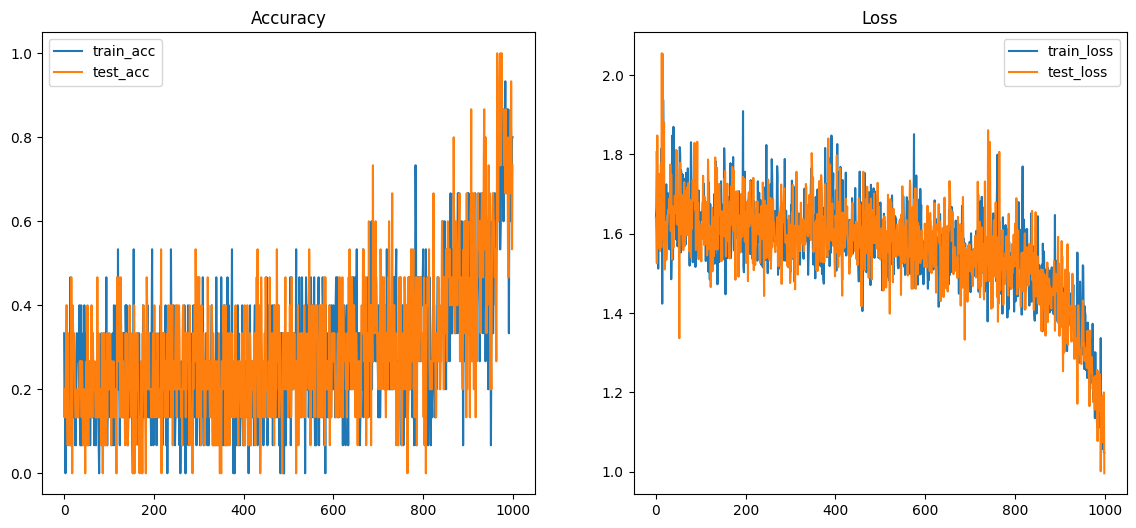

In [16]:
# meta training
with tqdm(
    zip(train_dataloader, val_dataloader), total=config["num_task_batch_train"]
) as pbar:
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for task_batch_idx, (train_batch, val_batch) in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_train"]:
            break

        train_accuracy, train_loss = train_snail(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch=train_batch,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
        )
        val_accuracy, val_loss = test_snail(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch=val_batch,
            model=model,
            criterion=criterion,
        )

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        pbar.set_postfix(
            train_accuracy="{0:.4f}".format(train_accuracy),
            val_accuracy="{0:.4f}".format(val_accuracy),
            train_loss="{0:.4f}".format(train_loss),
            val_loss="{0:.4f}".format(val_loss),
        )
    train_accuracies_avg = np.mean(train_accuracies)
    train_accuracies_std = np.std(train_accuracies)
    val_accuracies_avg = np.mean(val_accuracies)
    val_accuracies_std = np.std(val_accuracies)
    print("\nTrain Accuracies - Average: {:.4f}, ± {:.4f}".format(train_accuracies_avg, 1.96*(train_accuracies_std/np.sqrt(len(train_accuracies)))))
    print("Validation Accuracies - Average: {:.4f}, ± {:.4f}".format(val_accuracies_avg, 1.96*(val_accuracies_std/np.sqrt(len(val_accuracies)))))

    # model save
    save_model(output_folder=config["output_folder"], model=model, title="snail1.th")

    print_graph(
        train_accuracies=train_accuracies,
        val_accuracies=val_accuracies,
        train_losses=train_losses,
        val_losses=val_losses,
    )

In [17]:
# 모델 불러오기
load_model(output_folder=config["output_folder"], model=model, title="snail1.th")

# 메타-테스팅
with tqdm(test_dataloader, total=config["num_task_batch_test"]) as pbar:
    sum_test_accuracies = 0.0
    sum_test_losses = 0.0
    test_accuracies = [] 
    for task_batch_idx, test_batch in enumerate(pbar):
        if task_batch_idx >= config["num_task_batch_test"]:
            break

        test_accuracy, test_loss = test_snail(
            num_ways=config["num_ways"],
            num_shots=config["num_shots"],
            device=config["device"],
            task_batch=test_batch,
            model=model,
            criterion=criterion,
        )
        test_accuracies.append(test_accuracy)
        sum_test_accuracies += test_accuracy
        sum_test_losses += test_loss
        pbar.set_postfix(
            test_accuracy="{0:.4f}".format(sum_test_accuracies / (task_batch_idx + 1)),
            test_loss="{0:.4f}".format(sum_test_losses / (task_batch_idx + 1)),
        )

test_accuracy_avg = np.mean(test_accuracies)  # Calculate the average of test_accuracies list
test_accuracy_std = np.std(test_accuracies)  # Calculate the standard deviation of test_accuracies list

# Print the average and 95% confidence interval
print("\nTest Accuracies - Average: {:.4f}, ± {:.4f}".format(test_accuracy_avg, 1.96 * (test_accuracy_std / np.sqrt(len(test_accuracies)))))


Model is loaded


100%|████████████████████████████████████████| 300/300 [00:39<00:00,  7.56it/s, test_accuracy=0.6449, test_loss=1.1137]


Test Accuracies - Average: 0.6449, ± 0.0139


*Refrences 
https://github.com/dongminlee94/meta-learning-for-everyone